# Ultrasound
## A possible medical application of style transfer

This notebook will load a trained Netter style image model and apply it to ultrasound content images.

In [1]:
Get Dependencies
!wget -cO - https://github.com/Ouwen/MimickNet/blob/master/examples/models/python_mimicknet.h5?raw=true > python_mimicknet.h5
!git clone https://github.com/ouwen/datasets.git # Not needed once duke_ultrasound is integrated into the official repo
!pip3 install tensorflow-datasets
!pip3 install polarTransform

%cd datasets
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

/home/jupyter/BME590-Perceptual-Loss-Style-Transfer/datasets


In [2]:
# set data_dir locally for faster performance
# note that download and extraction can take ~3 hours
ds = tfds.load('duke_ultrasound', data_dir='gs://duke-tfds')

In [3]:
%cd ..
from trainer.utils import losses
from trainer.utils.utils import load_img, imshow, scan_convert, process, just_das
from trainer.models.transformer import transformer_model

train_ds = ds['MARK'].map(process) # Splits: MARK, TRAIN, VALIDATION, TEST, A, B
train_ds = train_ds.batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

/home/jupyter/BME590-Perceptual-Loss-Style-Transfer
(512, 512, 3)


(1, 469, 402, 3)


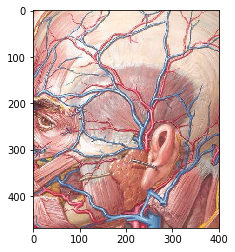

In [4]:
face = load_img('images/styles/face_crop.jpg')
print(face.shape)
imshow(face.numpy().astype(np.uint8))

In [10]:
model = transformer_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=losses.full_loss(face))
model.load_weights('trained_models/trained/face_cropped.h5')

created


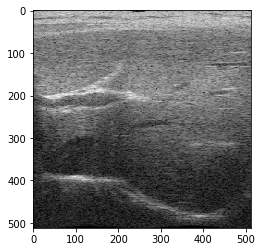

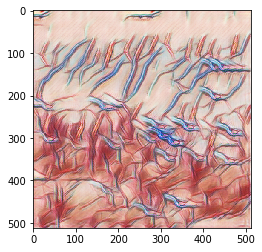

In [11]:
train_iter = iter(train_ds)
x,y = next(train_iter)
plt.figure()
plt.imshow(x[0].numpy())
results = model.predict(x)
plt.figure()
plt.imshow(results[0].astype(np.uint8))

In [47]:
# save input ultrasound image
xin = x[0].numpy()*255.
xin = tf.dtypes.cast(xin, tf.uint8)
encoded_str = tf.image.encode_jpeg(tf.squeeze(xin), quality=100)
tf.io.write_file('ultrasound_input.jpg', encoded_str)

In [7]:
# save output ultrasound image
results = tf.dtypes.cast(results[0], tf.uint8)
encoded_str = tf.image.encode_jpeg(tf.squeeze(results), quality=100)
tf.io.write_file('ultrasound_output.jpg', encoded_str)